In [27]:
# Hebbian Anti-Hebbian Mnist Demo
# By Karry
# Date: 2025.04.16
# For Introduction to Cognitive Neuroscience

In [5]:
!pip install numpy
!pip install keras
!pip install matplotlib

In [6]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [4]:
# Network
class Hebb_Network():
    
    def __init__(self, n_input, n_output, alpha=0.01, beta=0.001, gamma=0.01, lam=10, p=0.1, training_steps=100):
        self.n_input = n_input
        self.n_output = n_output
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lam = lam
        self.p = p
        self.training_steps = training_steps
        self.ff_weights = np.random.uniform(low=0., high=1., size=(n_output, n_input))
        self.ff_weights = self.ff_weights / self.ff_weights.sum(axis=1, keepdims=True)
        self.fb_weights = np.zeros(shape=(n_output, n_output))
        self.thresholds = np.random.uniform(low=0., high=1., size=(n_output, 1))
                                            
    def sigmoid(self, x):
        return 1/(1 + np.exp(-self.lam * x))
                                            
    def update_weights(self, x, y):
        yt = y[:, np.newaxis]
        del_w = -self.alpha * (y * yt - np.power(self.p, 2))
        self.fb_weights += del_w
        self.fb_weights[self.fb_weights > 0] = 0
        np.fill_diagonal(self.fb_weights, 0)

        # 前馈权重更新
        del_q = self.beta * y[:, np.newaxis] * (x[np.newaxis, :] - self.ff_weights)
        self.ff_weights += del_q

        # 反馈权重更新
        del_t = self.gamma * (y - self.p)
        self.thresholds += del_t[:, np.newaxis]

    def train(self, x_batch, vis_step=None):
        for step in range(self.training_steps):
            for i, x in enumerate(x_batch):
                output = self.predict(x)
                self.update_weights(x, output)

            if vis_step is not None and step % vis_step == 0:
                print(f"Step {step}: last output = {output}")
                self.visualize_weights(step)

    def visualize_weights(self, step=None):
        fig, axs = plt.subplots(1, self.n_output, figsize=(12, 3))
        for i in range(self.n_output):
            ax = axs[i] if self.n_output > 1 else axs
            weight_img = self.ff_weights[i].reshape(28, 28)
            im = ax.imshow(weight_img, cmap='hot')
            ax.set_title(f"Neuron {i}")
            ax.axis('off')
        fig.suptitle(f"Feedforward Weights at Step {step}")
        plt.tight_layout()
        plt.show()
                            
                                            
    def predict(self, x):
        qx = np.dot(self.ff_weights, x)
        y = np.zeros(self.n_output)
        thresholds = self.thresholds.squeeze()

        for _ in range(100):
            wy = np.dot(self.fb_weights, y)
            dydt = qx + wy - thresholds
            dydt = self.sigmoid(dydt) - y
            y += 0.01 * dydt

        output = np.zeros(self.n_output)
        output[y > 0.5] = 1
        return output   

In [7]:
# importing MNIST dataset
(train_x, train_y), (test_x, test_y) = mnist.load_data()

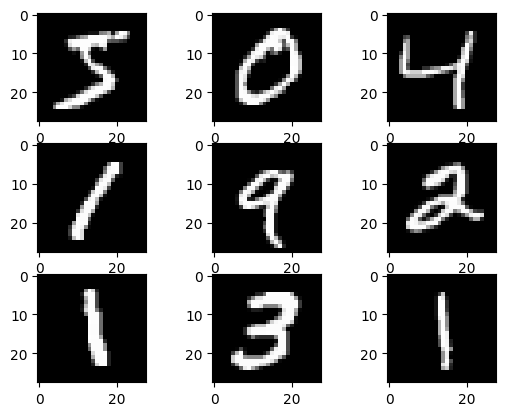

In [8]:
# plotting some of the digits
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.show

In [9]:
print(train_x.shape)

(60000, 28, 28)


In [10]:
# flattening and normalizing the input
train_x_reshape = np.reshape(train_x, (60000, 28*28))
train_x_reshape = train_x_reshape / np.amax(train_x_reshape)

In [11]:
print(train_x_reshape.shape)

(60000, 784)


In [12]:
# initializing the network
hebb = Hebb_Network(n_input=784, n_output=10, training_steps=5, p=0.25)

Step 0: last output = [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]


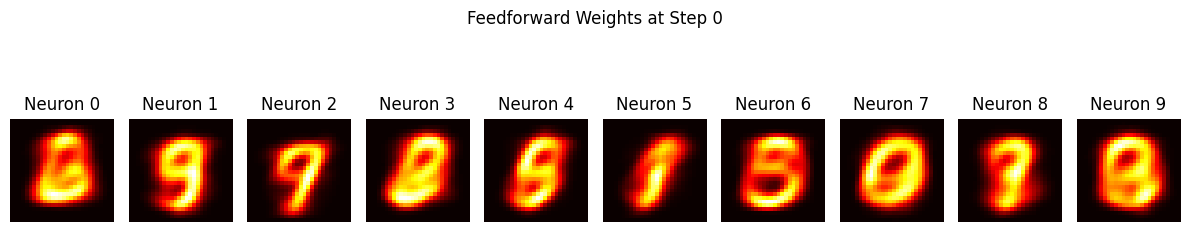

Step 1: last output = [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]


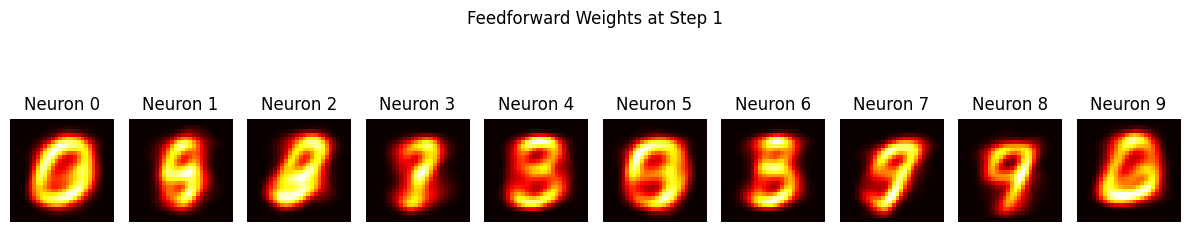

Step 2: last output = [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


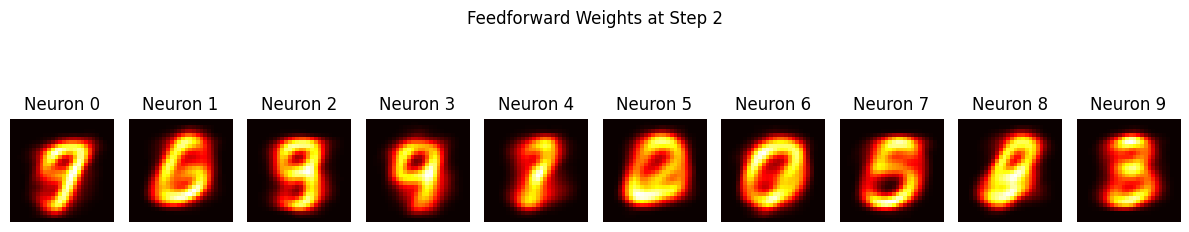

Step 3: last output = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


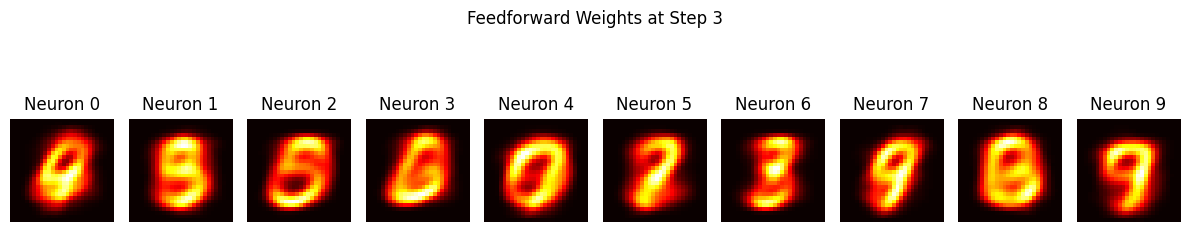

Step 4: last output = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


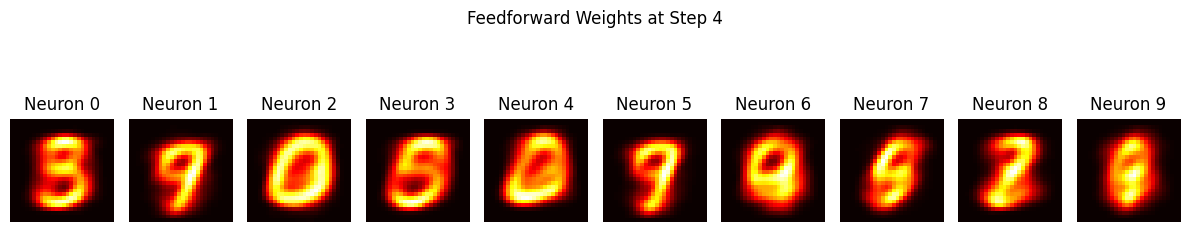

In [13]:
# training the network
hebb.train(train_x_reshape, vis_step=1)

In [15]:
# functions for testing the representational units
def create_single_digit_set(digit, train_x=train_x_reshape, train_y=train_y):
    single_digit_array = train_x[train_y==digit]
    return single_digit_array

def test_coding(network, data, n_output):
    outputs = np.zeros((data.shape[0], n_output))
    for i in range(data.shape[0]):
        digit = data[i, :]
        output = network.predict(digit)
        output = output.T
        outputs[i, :] = output
    outputs_mean = np.mean(outputs, axis=0)
    return outputs_mean    

Mean vector for digit 0:
[0.32736789 0.13776802 0.89599865 0.80043897 0.59176093 0.006078
 0.23450954 0.14958636 0.02566267 0.1912882 ]
_____________________________________________________________
Mean vector for digit 1:
[3.72293088e-02 5.19133788e-03 1.48323939e-04 1.03826758e-03
 1.34974785e-02 3.38178582e-02 3.41145061e-03 9.40373776e-02
 4.20498368e-01 3.29427470e-01]
_____________________________________________________________
Mean vector for digit 2:
[0.26888218 0.07099698 0.25763679 0.04900973 0.66179926 0.04514938
 0.612286   0.00755287 0.48606915 0.42833165]
_____________________________________________________________
Mean vector for digit 3:
[0.86233893 0.1003099  0.07894308 0.55374327 0.13815038 0.10357201
 0.1268961  0.10960692 0.44120046 0.21464688]
_____________________________________________________________
Mean vector for digit 4:
[0.01763095 0.32865457 0.28808627 0.00290996 0.01694625 0.44796303
 0.68606642 0.24443684 0.01523451 0.31444711]
_______________________

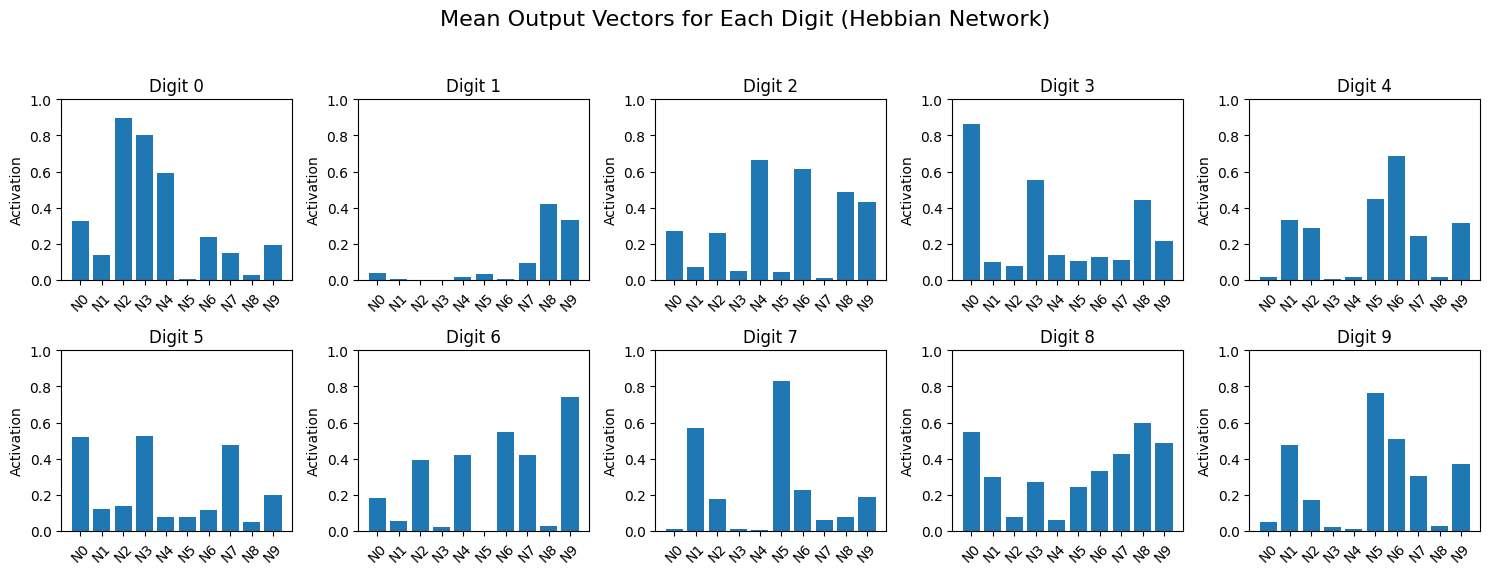

In [16]:
# creating mean output vectors
output_vectors = []
for i in range(10):
    digits = create_single_digit_set(i)
    output = test_coding(hebb, digits, 10)
    print(f"Mean vector for digit {i}:")
    print(output)
    output_vectors.append(output)
    print("_____________________________________________________________")
    
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(10):
    axs[i].bar(range(10), output_vectors[i])
    axs[i].set_title(f"Digit {i}")
    axs[i].set_ylim(0, 1)
    axs[i].set_xticks(range(10))
    axs[i].set_xticklabels([f"N{j}" for j in range(10)], rotation=45)
    axs[i].set_ylabel("Activation")

plt.suptitle("Mean Output Vectors for Each Digit (Hebbian Network)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
# amounts of every digit in data set:
for i in range(10):
    digits = create_single_digit_set(i)
    print(f"{i} ::: {digits.shape[0]}")

0 ::: 5923
1 ::: 6742
2 ::: 5958
3 ::: 6131
4 ::: 5842
5 ::: 5421
6 ::: 5918
7 ::: 6265
8 ::: 5851
9 ::: 5949


Example output vectors for digit 0
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 1. 0. 1. 0. 0. 0.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
------------------------------------
Example output vectors for digit 1
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
------------------------------------
Example output vectors for digit 2
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
------------------------------------
Example output vectors for digit 3
[1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
------------------------------------
Example output vectors for digit 4
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1

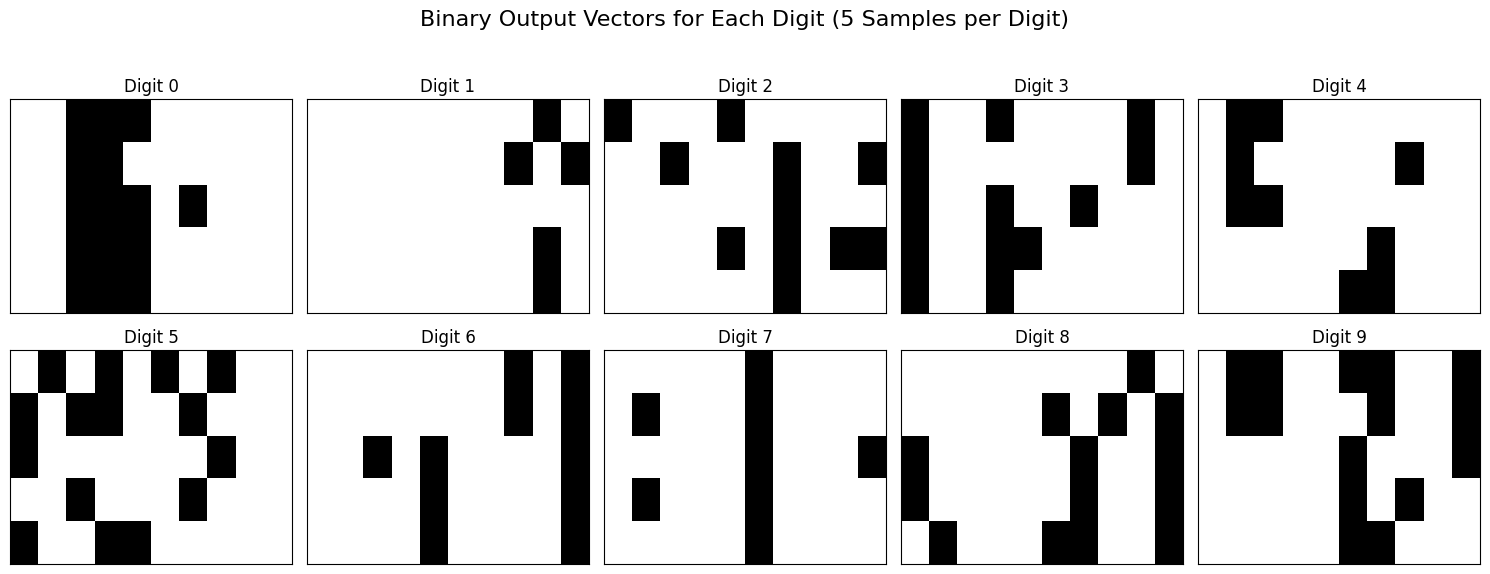

In [19]:
# creating multiple example output vectors for every digit
digital=[]

for i in range(10):
    vec=[]
    digits = create_single_digit_set(i)
    rng = np.random.default_rng()
    sample_digit = rng.choice(digits, 5)
    print(f"Example output vectors for digit {i}")
    for j in range(sample_digit.shape[0]):
        digit = sample_digit[j, :]
        output_vector = hebb.predict(digit)
        output_vector = output_vector.T
        vec.append(output_vector)
        print(f"{output_vector}")
    digital.append(vec)
    print("------------------------------------")


            
            
# 可视化每个 digit 的 5 个样本输出向量（0=白，1=黑）
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(10):
    ax = axs[i]
    mat = np.array(digital[i])  # shape: (5, 10)
    ax.imshow(mat, cmap="gray_r", aspect="auto", vmin=0, vmax=1)
    ax.set_title(f"Digit {i}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Binary Output Vectors for Each Digit (5 Samples per Digit)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [21]:
print(test_x.shape)

(10000, 28, 28)


In [22]:
# flattening and normalizing the test data set
test_x_reshape = np.reshape(test_x, (10000, 28*28))
test_x_reshape = test_x_reshape / np.amax(test_x_reshape)

Mean vector for digit 0:
[0.33877551 0.12653061 0.90816327 0.78265306 0.59795918 0.00306122
 0.2744898  0.13367347 0.02653061 0.19489796]
_____________________________________________________________
Mean vector for digit 1:
[0.04140969 0.00440529 0.         0.         0.01321586 0.02643172
 0.00264317 0.09339207 0.41938326 0.37621145]
_____________________________________________________________
Mean vector for digit 2:
[0.31976744 0.0746124  0.25       0.06104651 0.67054264 0.04166667
 0.58430233 0.00484496 0.5494186  0.44767442]
_____________________________________________________________
Mean vector for digit 3:
[0.8960396  0.11188119 0.07722772 0.56534653 0.14059406 0.0980198
 0.11683168 0.12772277 0.44653465 0.25544554]
_____________________________________________________________
Mean vector for digit 4:
[0.02240326 0.3401222  0.28716904 0.         0.01731161 0.4796334
 0.71384929 0.22810591 0.01832994 0.33299389]
_____________________________________________________________
Me

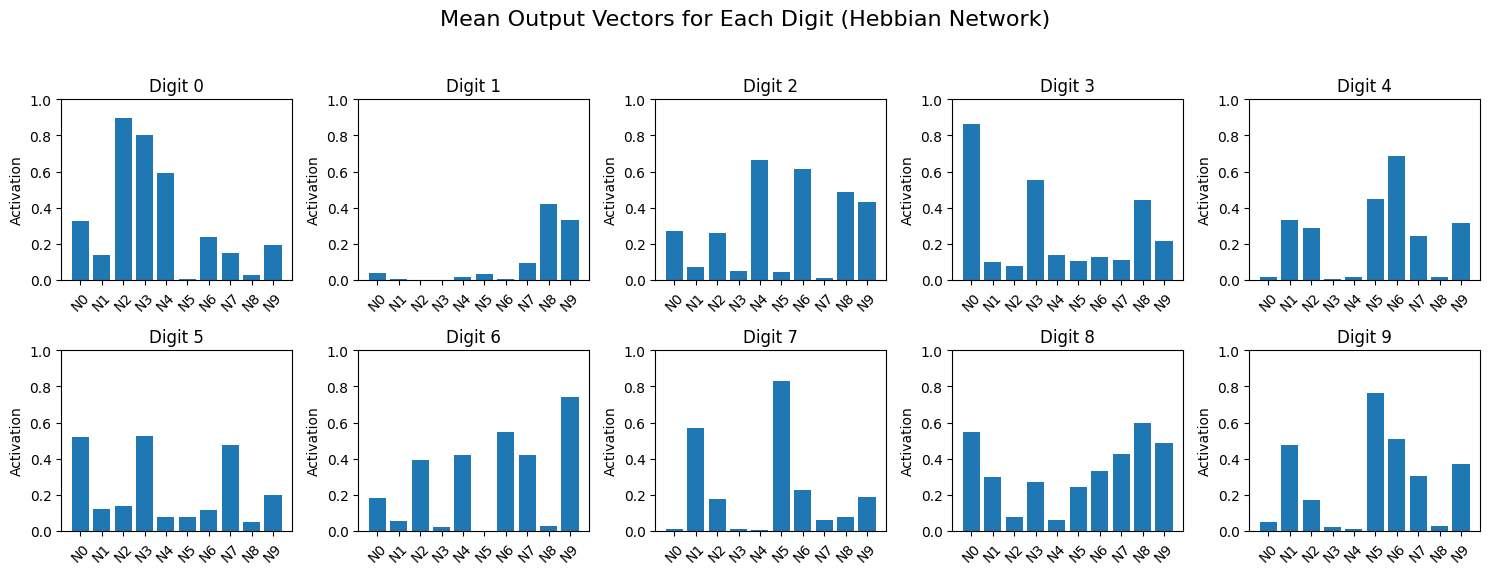

In [24]:
# creating mean output vectors for the test data set
for i in range(10):
    digits = create_single_digit_set(i, train_x=test_x_reshape, train_y=test_y)
    output = test_coding(hebb, digits, 10)
    print(f"Mean vector for digit {i}:")
    print(output)
    print("_____________________________________________________________")
    
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(10):
    axs[i].bar(range(10), output_vectors[i])
    axs[i].set_title(f"Digit {i}")
    axs[i].set_ylim(0, 1)
    axs[i].set_xticks(range(10))
    axs[i].set_xticklabels([f"N{j}" for j in range(10)], rotation=45)
    axs[i].set_ylabel("Activation")

plt.suptitle("Mean Output Vectors for Each Digit (Hebbian Network)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Example output vectors for digit 0
[0. 1. 1. 1. 1. 0. 0. 1. 0. 1.]
[0. 0. 1. 1. 1. 0. 1. 0. 0. 0.]
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 0. 0. 1. 0. 1.]
------------------------------------
Example output vectors for digit 1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
------------------------------------
Example output vectors for digit 2
[0. 1. 1. 0. 1. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
[0. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
[1. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
------------------------------------
Example output vectors for digit 3
[1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
[1. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
------------------------------------
Example output vectors for digit 4
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0

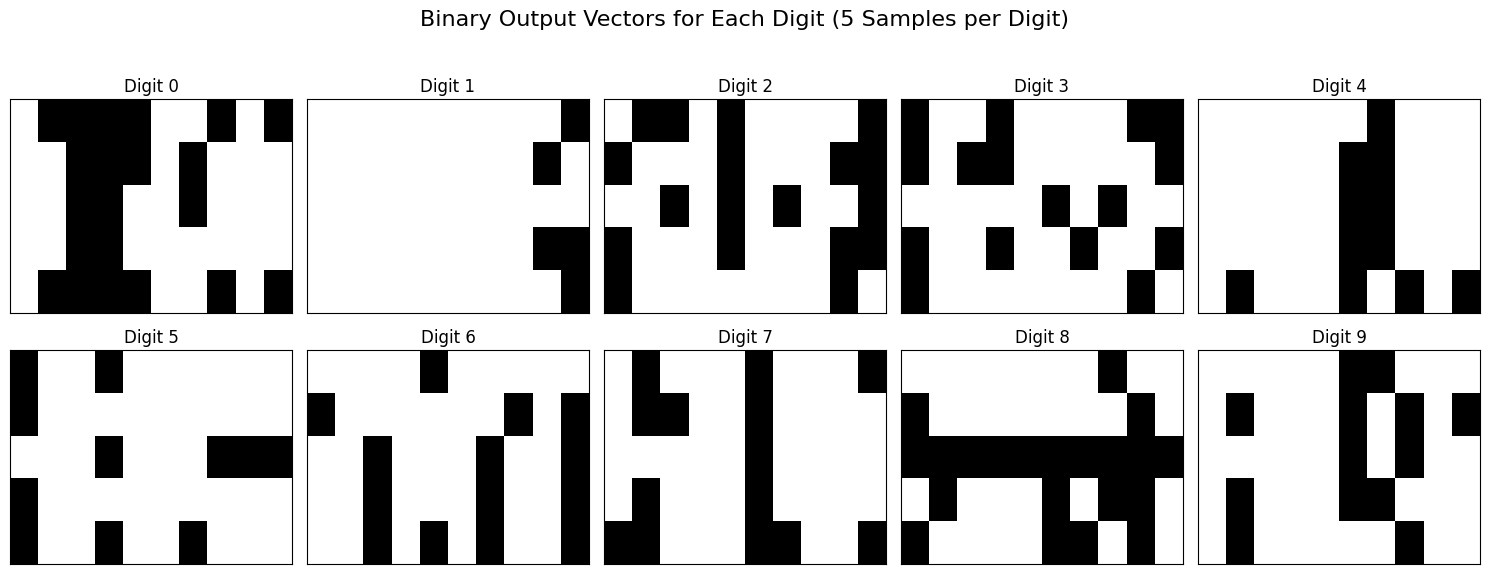

In [25]:
# creating multiple example output vectors for the test data set
digital=[]
for i in range(10):
    vec=[]
    digits = create_single_digit_set(i, train_x=test_x_reshape, train_y=test_y)
    rng = np.random.default_rng()
    sample_digit = rng.choice(digits, 5)
    print(f"Example output vectors for digit {i}")
    for j in range(sample_digit.shape[0]):
        digit = sample_digit[j, :]
        output_vector = hebb.predict(digit)
        output_vector = output_vector.T
        vec.append(output_vector)
        print(f"{output_vector}")
    digital.append(vec)
    print("------------------------------------")
    
    

            
# 可视化每个 digit 的 5 个样本输出向量（0=白，1=黑）
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(10):
    ax = axs[i]
    mat = np.array(digital[i])  # shape: (5, 10)
    ax.imshow(mat, cmap="gray_r", aspect="auto", vmin=0, vmax=1)
    ax.set_title(f"Digit {i}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Binary Output Vectors for Each Digit (5 Samples per Digit)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()